In [40]:
import itk
import sys

#for plot
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def plot_image(image_):
    array = itk.array_view_from_image(image_)

    # Plot the image using Matplotlib
    plt.imshow(array, cmap="gray")
    plt.show()
    return None

In [42]:
inputFileName = 'images/originalImage.png'
maskFileName = 'images/mask1.png'
outputFileName = 'output_images/result_filter_1.png'

In [43]:
Dimension = 2
PixelType = itk.F
RealImageType = itk.Image[PixelType, Dimension]
CharPixelType = itk.UC
CharImageType = itk.Image[CharPixelType, Dimension]
ComplexImageType = itk.Image[itk.complex[PixelType], Dimension]

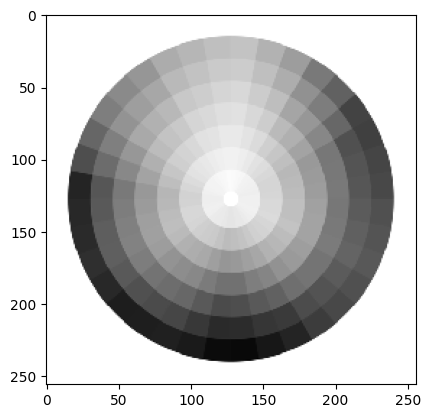

In [44]:
inputReader = itk.ImageFileReader[RealImageType].New( )
inputReader.SetFileName( inputFileName )
inputReader.Update()

plot_image(inputReader)
  

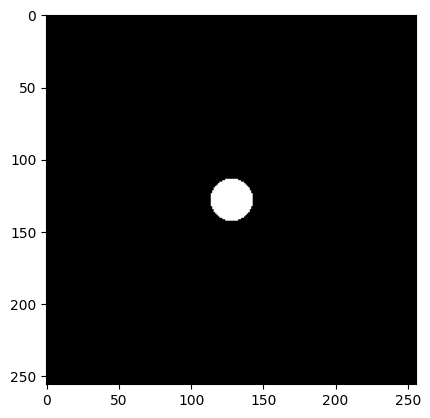

In [45]:
maskReader = itk.ImageFileReader[CharImageType].New( )
maskReader.SetFileName( maskFileName )
maskReader.Update()

plot_image(maskReader)

In [59]:
ForwardFFTFilterType = itk.ForwardFFTImageFilter[RealImageType, ComplexImageType]
forwardFFTFilter = ForwardFFTFilterType.New( )
forwardFFTFilter.SetInput( inputReader.GetOutput() )
forwardFFTFilter.UpdateOutputInformation()
forwardFFTFilter.Update()



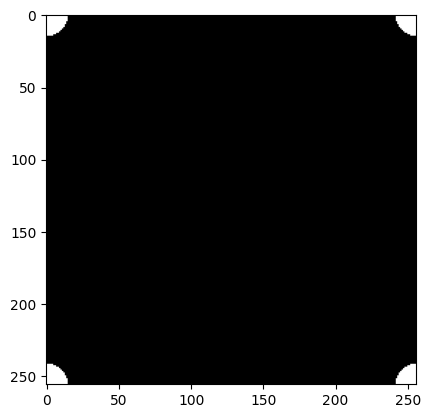

In [47]:
FFTShiftFilterType = itk.FFTShiftImageFilter[CharImageType, CharImageType]
fftShiftFilter = FFTShiftFilterType.New( )
fftShiftFilter.SetInput( maskReader.GetOutput() )
fftShiftFilter.Update()

plot_image(fftShiftFilter)

In [48]:
    
MaskFilterType = itk.MaskImageFilter[ComplexImageType, CharImageType, ComplexImageType] 
maskFilter = MaskFilterType.New( )
maskFilter.SetInput1( forwardFFTFilter.GetOutput() )
maskFilter.SetInput2( fftShiftFilter.GetOutput() )
maskFilter.Update()


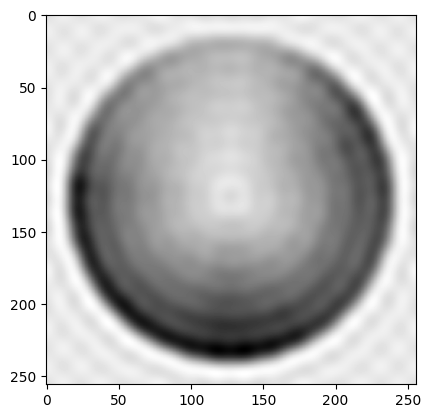

In [49]:
InverseFilterType = itk.InverseFFTImageFilter[ComplexImageType, RealImageType]
inverseFFTFilter = InverseFilterType.New()
inverseFFTFilter.SetInput( maskFilter.GetOutput() )
inverseFFTFilter.Update()

plot_image(inverseFFTFilter)

In [50]:
MinMaxFilterType = itk.MinimumMaximumImageFilter[RealImageType]
minMaxFilter = MinMaxFilterType.New()
minMaxFilter.SetInput( inverseFFTFilter.GetOutput() )
minMaxFilter.Update()


In [51]:
min_int = minMaxFilter.GetMinimum()
max_int = minMaxFilter.GetMaximum()
int_range = max_int - min_int

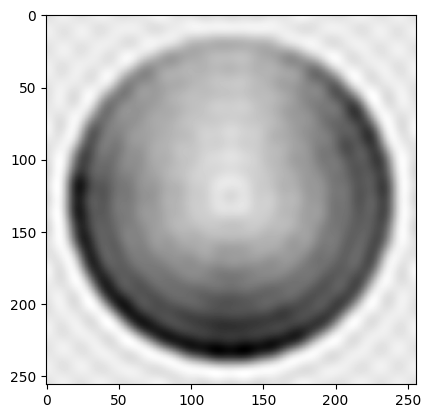

In [52]:
IntShiftFilterType = itk.ShiftScaleImageFilter[RealImageType, RealImageType]
intShiftFilter = IntShiftFilterType.New()
intShiftFilter.SetInput( inverseFFTFilter.GetOutput() )
intShiftFilter.SetShift( - min_int )
intShiftFilter.Update()

plot_image(intShiftFilter)

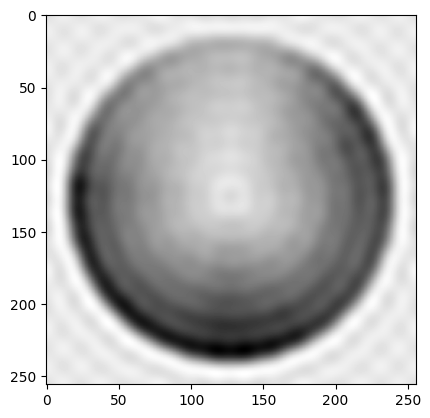

In [53]:
RescaleFilterType = itk.RescaleIntensityImageFilter[RealImageType, RealImageType]
rescaleFilter = RescaleFilterType.New( )
if int_range > 255 and min_int < 0 :
  rescaleFilter.SetInput( intShiftFilter.GetOutput() )
else :
  rescaleFilter.SetInput( inverseFFTFilter.GetOutput() )
rescaleFilter.SetOutputMinimum( 0 )
rescaleFilter.SetOutputMaximum( 255 )
rescaleFilter.Update()

plot_image(rescaleFilter)

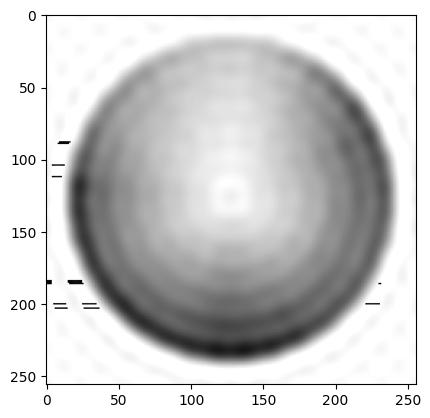

In [54]:

CastFilterType = itk.CastImageFilter[RealImageType, CharImageType]
castFilter = CastFilterType.New( )
if int_range > 255 :
  castFilter.SetInput( rescaleFilter.GetOutput() )
elif min_int < 0 :
  castFilter.SetInput( intShiftFilter.GetOutput() )
else :
  castFilter.SetInput( inverseFFTFilter.GetOutput() )
castFilter.Update()

plot_image(castFilter)

In [55]:
WriterType = itk.ImageFileWriter[CharImageType]
writer = WriterType.New( )
writer.SetFileName( outputFileName )
writer.SetInput( castFilter.GetOutput() )
writer.Update()